The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-tvm
!pip install https://tvm-repo.s3-us-west-2.amazonaws.com/tvm-0.7.dev1-cp37-cp37m-linux_x86_64.whl https://tvm-repo.s3-us-west-2.amazonaws.com/topi-0.7.dev1-py3-none-any.whl


# Pooling
:label:`ch_pooling_gpu`

In this section, we will optimize pooling on GPUs. It is relatively easy compared to the schedulings we discussed for `matmul` and `conv`.


In [1]:
import d2ltvm
import numpy as np
import timeit
import tvm
from tvm import te

target = 'cuda'

## Scheduling

### Max Pooling

Like scheduling on CPUs at :numref:`ch_pooling_cpu`, we first use `compute_inline` to inject the padding compute into the pooling stage of `max pooling`. After that, what we are scheduling is essentially two-level for loop traversal of a two-level reduction.

It is easy to see that we can attach the two-level traversal to CUDA blocks and threads respectively. As CUDA threads in the same CUDA block will be run in the same SM (review :numref:`ch_vector_add_gpu` if you forget those concepts) and `max pooling` is a memory bound operator, we maximize the number of threads in the block.

Another scheduling approach we usually take in GPUs is managing the memory hierarchy. In this case, we want to bring the two-level reduction to the local memory for computation.

Finally, we can print out the IR to check.


In [2]:
# attain the maximal number of threads of a CUDA block
nt = 0
with tvm.target.create(target):
    nt = tvm.target.Target.current(allow_none=False).max_num_threads

def schedule_max(size):
    c, n, k = size[:]
    X, Y, PaddedX = d2ltvm.pool('max', c, n, n, k, k, 1, 1, 1, 1)
    sch = te.create_schedule(Y.op)
    sch[PaddedX].compute_inline()
    # traversal axes binding
    fused = sch[Y].fuse(*sch[Y].op.axis)
    bx, tx = sch[Y].split(fused, factor=nt)
    sch[Y].bind(bx, te.thread_axis("blockIdx.x"))
    sch[Y].bind(tx, te.thread_axis("threadIdx.x"))
    
    return sch, (X, Y)

# (channel, input width and height, kernel width and height)
size = (64, 64, 3)
sch, args = schedule_max(size)
print(tvm.lower(sch, args, simple_mode=True))

produce PoolMax {
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 256
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 1024
  PoolMax[((blockIdx.x*1024) + threadIdx.x)] = -3.40282e+38f
  for (rkh, 0, 3) {
    for (rkw, 0, 3) {
      PoolMax[((blockIdx.x*1024) + threadIdx.x)] = max(PoolMax[((blockIdx.x*1024) + threadIdx.x)], tvm_if_then_else((((((rkh + floormod(((blockIdx.x*16) + floordiv(threadIdx.x, 64)), 64)) < 1) || (65 <= (rkh + floormod(((blockIdx.x*16) + floordiv(threadIdx.x, 64)), 64)))) || ((rkw + floormod(threadIdx.x, 64)) < 1)) || (65 <= (rkw + floormod(threadIdx.x, 64)))), -3.40282e+38f, X[(((((blockIdx.x*1024) + (rkh*64)) + threadIdx.x) + rkw) - 65)]))
    }
  }
}



### Avg Pooling

`Avg pooling` is similar to `max pooling` except that there are two stages for the pooling computation. As discussed at :numref:`ch_pooling_cpu`, we used the `compute_at` scheduling primitive to merge the two stages. Other than that, `avg pooling` reuses the scheduling scheme of `max pooling`.

We also print out the IR for observation.


In [3]:
def schedule_avg(size):
    c, n, k = size[:]
    X, Y, PaddedX = d2ltvm.pool('avg', c, n, n, k, k, 1, 1, 1, 1)
    sch = te.create_schedule(Y.op)
    sch[PaddedX].compute_inline()

    # traversal axes binding
    fused = sch[Y].fuse(*sch[Y].op.axis)
    bx, tx = sch[Y].split(fused, factor=nt)
    sch[Y].bind(bx, te.thread_axis("blockIdx.x"))
    sch[Y].bind(tx, te.thread_axis("threadIdx.x"))

    # merging two stages
    PoolSum = Y.op.input_tensors[0]  
    sch[PoolSum].compute_at(sch[Y], tx)   
    return sch, (X, Y)

# (channel, input width and height, kernel width and height)
size = (64, 64, 3)
sch, args = schedule_avg(size)
mod = tvm.build(sch, args, target)
print(tvm.lower(sch, args, simple_mode=True))

produce PoolAvg {
  // attr [iter_var(blockIdx.x, , blockIdx.x)] thread_extent = 256
  // attr [PoolSum] storage_scope = "local"
  allocate PoolSum[float32 * 1]
  // attr [iter_var(threadIdx.x, , threadIdx.x)] thread_extent = 1024
  produce PoolSum {
    PoolSum[0] = 0f
    for (rkh, 0, 3) {
      for (rkw, 0, 3) {
        PoolSum[0] = (PoolSum[0] + tvm_if_then_else((((((rkh + floormod(((blockIdx.x*16) + floordiv(threadIdx.x, 64)), 64)) < 1) || (65 <= (rkh + floormod(((blockIdx.x*16) + floordiv(threadIdx.x, 64)), 64)))) || ((rkw + floormod(threadIdx.x, 64)) < 1)) || (65 <= (rkw + floormod(threadIdx.x, 64)))), 0f, X[(((((blockIdx.x*1024) + (rkh*64)) + threadIdx.x) + rkw) - 65)]))
      }
    }
  }
  PoolAvg[((blockIdx.x*1024) + threadIdx.x)] = (PoolSum[0]*0.111111f)
}



## Benchmarking

We use the pooling implementation of GPU in MXNet as the baseline. The benchmarking code can be reused from :numref:`ch_pooling_cpu`. Note that for TVM, we set `target` to be CUDA; for MXNet, we set `ctx` to be gpu.

First, compare the `max pooling`.


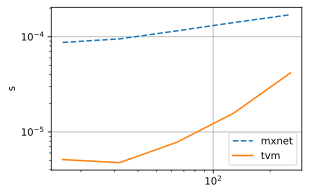

In [4]:
channels = 2**np.arange(4, 9)
# a list of (c, n, k)
sizes = [(int(c), 64, 3) for c in channels]

tvm_max_times = d2ltvm.bench_pooling_tvm(schedule_max, sizes, target)
mxnet_max_times = d2ltvm.bench_pooling_mxnet('max', sizes, ctx='gpu')

times = [mxnet_max_times, tvm_max_times]
d2ltvm.plot(channels, times, ylabel='s',
            xscale='log', yscale='log',
            legend=['mxnet', 'tvm'], fmts=['--']*(len(times)-1)+['-'])

Then, compare the `avg pooling`.


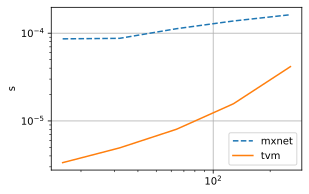

In [5]:
tvm_avg_times = d2ltvm.bench_pooling_tvm(schedule_avg, sizes, target)
mxnet_avg_times = d2ltvm.bench_pooling_mxnet('avg', sizes, ctx='gpu')

times = [mxnet_avg_times, tvm_avg_times]
d2ltvm.plot(channels, times, ylabel='s',
            xscale='log', yscale='log',
            legend=['mxnet', 'tvm'], fmts=['--']*(len(times)-1)+['-'])

Note that we are plotting execution times, so low is better. Both results show that TVM completes pooling computation much faster than MXNet.

## Summary
- Scheduling pooling on GPUs are analogous to scheduling on CPUs, similar tricks can be used, e.g. `compute_inline` and `compute_at`.
- Other than that, GPU specific optimization tricks are also used, e.g., thread and block binding.

## Exercise
- Use `cache_read` and `cache_write` primitives to further schedule pooling, observe if there is any improvement, and think about the reason.
